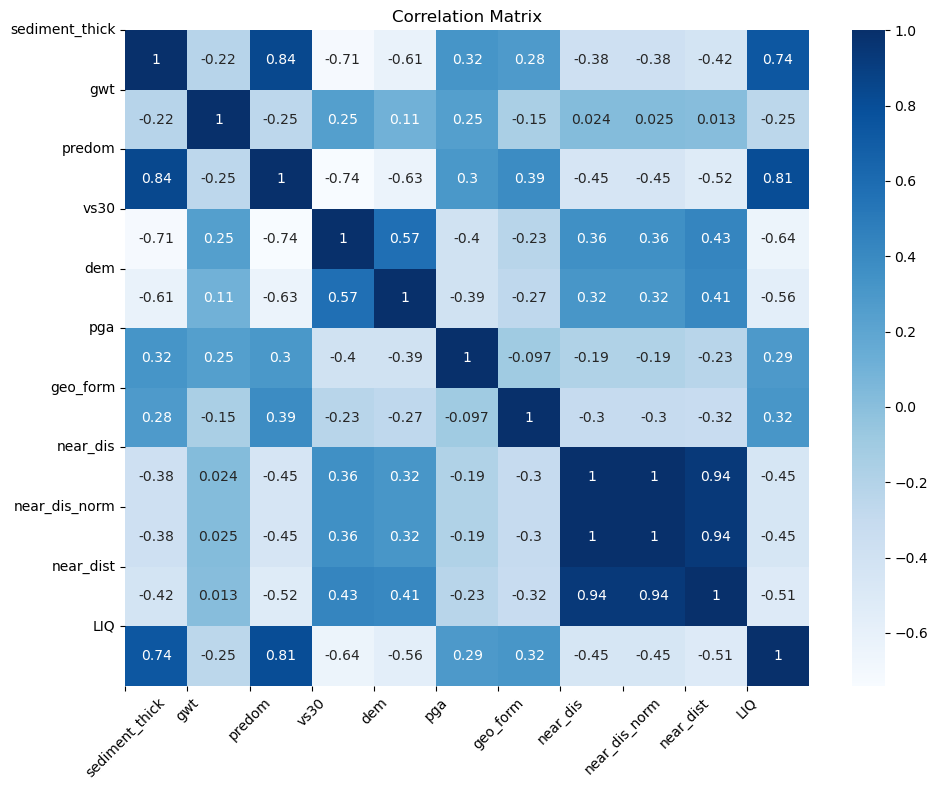

Variance Inflation Factor (VIF):
        VIF        features
0  2.769109        near_dis
1  8.492843  sediment_thick
2  8.988764          predom
3  8.696044            vs30
4  5.027700             pga
5  6.135978        geo_form
Feature Importance (Information Gain Ratio):
Feature 1: near_dis (importance: 0.181)
Feature 2: sediment_thick (importance: 0.314)
Feature 3: predom (importance: 0.380)
Feature 4: vs30 (importance: 0.264)
Feature 5: pga (importance: 0.123)
Feature 6: geo_form (importance: 0.331)


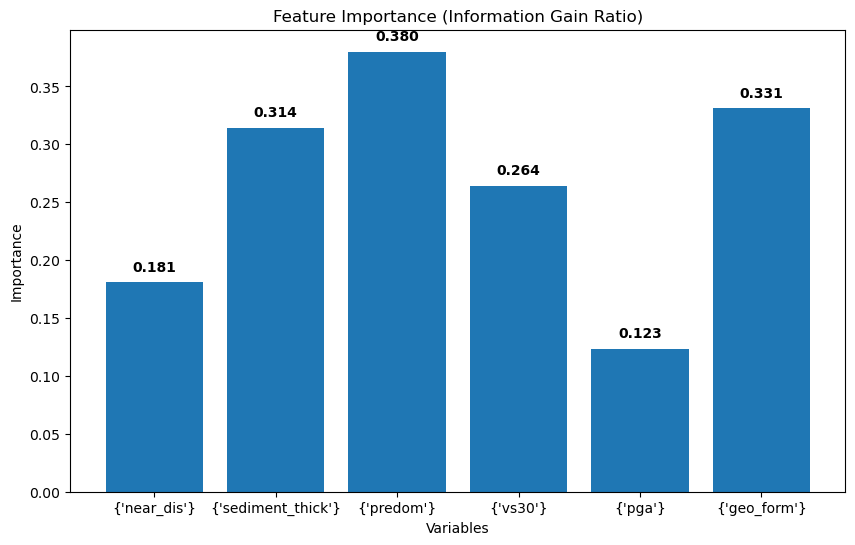

Accuracy: 0.909
Precision: 0.881
Recall: 0.825
F1 Score: 0.852
AUC Score (Test): 0.964
AUC Error (Test): 0.036
Cohen Kappa Score: 0.787


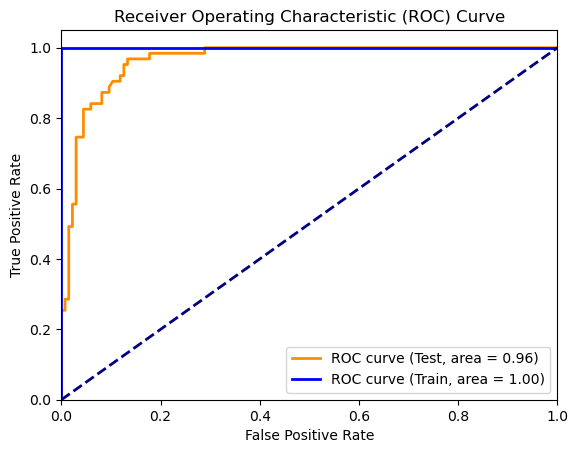

Confusion Matrix:
[[128   7]
 [ 11  52]]
True Positive Rate: 0.825
False Positive Rate: 0.052
True Negative Rate: 0.948
False Negative Rate: 0.175


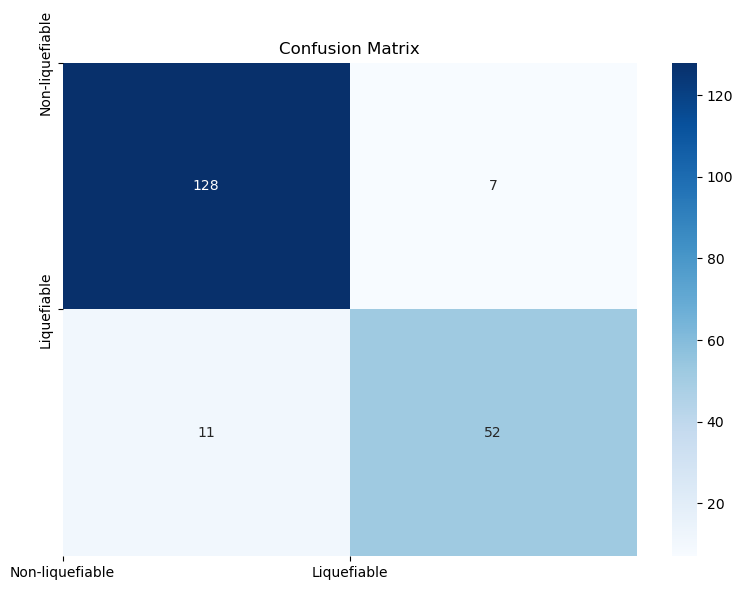

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif

# Define constants
TEST_SIZE = 0.3
RANDOM_STATE = 36
N_ESTIMATORS = 300
MAX_DEPTH = None
LEARNING_RATE = 0.1

# Load the dataset from a CSV file
file_path = "C:\\Users\\LE\\Downloads\\THESIS\\Program\\CSV\\GRID_LABEL_KTMBASIN_classify_v2.2.csv"
data = pd.read_csv(file_path)

# Calculate correlation of the dataset
correlation_matrix = data.corr()

# Draw heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title("Correlation Matrix")
tick_marks = [i for i in range(len(data.columns))]
plt.xticks(tick_marks, data.columns, rotation=45)
plt.yticks(tick_marks, data.columns)
plt.tight_layout()
plt.show()

# Preprocess the data
X = data[["near_dis", "sediment_thick", "predom", "vs30", "pga", "geo_form"]]
y = data["LIQ"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Calculate VIF
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['features'] = X_train.columns
print("Variance Inflation Factor (VIF):")
print(vif)

# Calculate feature importance using Information Gain Ratio
information_gain_ratio = mutual_info_classif(X_train, y_train)
print("Feature Importance (Information Gain Ratio):")
for i, importance in enumerate(information_gain_ratio):
    print(f"Feature {i+1}: {X.columns[i]} (importance: {importance:.3f})")

# Draw bar chart for feature importance using Information Gain Ratio
plt.figure(figsize=(10, 6))
plt.bar(range(len(information_gain_ratio)), information_gain_ratio, align="center")
plt.xticks(range(len(information_gain_ratio)), [{X.columns[i]} for i in range(len(information_gain_ratio))])
plt.xlabel("Variables")
plt.ylabel("Importance")
plt.title("Feature Importance (Information Gain Ratio)")
for i,v in enumerate(information_gain_ratio):
    plt.text(i,v+0.01,f"{v:.3f}", ha="center", weight="bold")
plt.show()

# Select a model based on the problem's requirements
model_type = "classifier"
if model_type == "classifier":
    model = XGBClassifier(random_state=RANDOM_STATE, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH, learning_rate=LEARNING_RATE)
elif model_type == "regressor":
    model = XGBRegressor(random_state=RANDOM_STATE, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH, learning_rate=LEARNING_RATE)

# Train the model
model.fit(X_train, y_train)

# For evaluation metrics
y_pred_test = model.predict(X_test)

# For Liquefaction Susceptibility Mappping
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
auc_score_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
auc_error_test = 1 - auc_score_test
kappa = cohen_kappa_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"AUC Score (Test): {auc_score_test:.3f}")
print(f"AUC Error (Test): {auc_error_test:.3f}")
print(f"Cohen Kappa Score: {kappa:.3f}")

# Plot AUROC curve for test data
y_pred_proba_test = model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot AUROC curve for train data
y_pred_proba_train = model.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
roc_auc_train = auc(fpr_train, tpr_train)

# Plot AUROC curves for both test and train data
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (Test, area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve (Train, area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_mat)

# Calculate true positive rate, false positive rate, true negative rate, false negative rate
tn, fp, fn, tp = conf_mat.ravel()
tpr = tp / (tp + fn)  # True positive rate
fpr = fp / (fp + tn)  # False positive rate
tnr = tn / (tn + fp)  # True negative rate
fnr = fn / (fn + tp)  # False negative rate

print(f"True Positive Rate: {tpr:.3f}")
print(f"False Positive Rate: {fpr:.3f}")
print(f"True Negative Rate: {tnr:.3f}")
print(f"False Negative Rate: {fnr:.3f}")

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt = '.0f')
plt.title("Confusion Matrix")
tick_marks = [i for i in range(2)]
plt.xticks(tick_marks, ["Non-liquefiable", "Liquefiable"], rotation=0)
plt.yticks(tick_marks, ["Non-liquefiable", "Liquefiable"])
plt.tight_layout()
plt.show()

In [5]:
mean_score = accuracy_score(y_test, y_pred_test)
print("Mean Score:", mean_score)

Mean Score: 0.9090909090909091


In [7]:
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

print(mse)
print(rmse)

0.09090909090909091
0.30151134457776363


In [5]:
import numpy as np

# Calculate standard deviation of each input parameter
std_near_dist = np.std(X_train['near_dis'])
std_sediment_thick = np.std(X_train['sediment_thick'])
std_vs30 = np.std(X_train['vs30'])
std_predom = np.std(X_train['predom'])
std_geoform = np.std(X_train['geo_form'])

# Calculate tolerance as 10% of standard deviation
tol_near_dist = std_near_dist * 0.1
tol_sediment_thick = std_sediment_thick * 0.1
tol_vs30 = std_vs30 * 0.1
tol_predom = std_predom * 0.1
tol_geoform = std_geoform * 0.1

print("Tolerance of input parameters:")
print(f"NEAR_DIST: {tol_near_dist:.3f}")
print(f"sediment_thick: {tol_sediment_thick:.3f}")
print(f"vs30: {tol_vs30:.3f}")
print(f"predom: {tol_predom:.3f}")
print(f"geomap: {tol_geoform:.3f}")

Tolerance of input parameters:
NEAR_DIST: 0.194
sediment_thick: 0.227
vs30: 0.062
predom: 0.298
geomap: 0.397


In [79]:
import geopandas as gpd
import numpy as np
import pandas as pd

# Read the shapefile
gdf = gpd.read_file(r'D:\\ARC GIS\\KTM VALLEY\\WGS_1984_UTM_ZONE_45N\\GRID\\GRID_LABEL_KTMBASIN_Classify_v2.2.shp')

# Repeat the predictions to match the number of features
y_pred_repeated = np.repeat(y_pred_proba_test, len(gdf) // len(y_pred_proba_test) + 1)[:len(gdf)]

# Create a new DataFrame with the repeated predictions
df = pd.DataFrame(y_pred_repeated, columns=['LSM'])

# Reset the index of the GeoDataFrame to create a unique index
gdf.reset_index(drop=True, inplace=True)

# Assign the repeated predictions to a new column in the GeoDataFrame
gdf['LSM'] = df['LSM']

# Set the CRS
gdf.set_crs(epsg=32645, inplace=True)

# Save the GeoDataFrame to a new shapefile
gdf.to_file(r'D:\\ARC GIS\\KTM VALLEY\\WGS_1984_UTM_ZONE_45N\\METHOD 2\\Classify_v2.2\\method2_grid_1_0.3_36_XGB_CLassify_v2.2.shp')

In [56]:
gdf.crs

<Projected CRS: EPSG:32645>
Name: WGS 84 / UTM zone 45N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°E and 90°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. India. Kazakhstan. Mongolia. Nepal. Russian Federation.
- bounds: (84.0, 0.0, 90.0, 84.0)
Coordinate Operation:
- name: UTM zone 45N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
import pandas as pd

# Create a DataFrame with X_test, y_test, and y_pred_test
df = pd.DataFrame(X_test, columns=X.columns)
df['LIQ'] = y_test
df['Predicted_LIQ'] = y_pred_test

# Print the DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(df)

# Export the DataFrame to an Excel file
df.to_excel('output_XBG.xlsx', index=False)

     near_dis  bedrockdep  predom  vs30  pga  geo_form  LIQ  Predicted_LIQ
100      1.03           6       9     2    5         7    1              1
170      1.17           7       9     2    4        13    1              1
315      6.78           1       2     2    8         4    0              0
445      1.10           1       1     3    1         9    0              0
428      3.91           3       1     3    2         8    0              0
254      0.05           3       8     2    4        11    1              1
490      2.59           1       1     3    1         9    0              0
60       2.59           1       1     3    5         6    0              0
524      2.55           1       1     3    1         9    0              0
135      0.03           7       9     2    5        11    1              1
348      1.31           1       1     3    5         3    0              0
334      7.45           1       1     3    4         2    0              0
495      1.99           1

Correlation Matrix:
                  Id  EASTING_X  NORTHING_Y  NEAR_DIST  bedrockdep       gwt  \
Id          1.000000   0.992609    0.992609   0.184710   -0.014659 -0.503268   
EASTING_X   0.992609   1.000000    1.000000   0.201224    0.036075 -0.526195   
NORTHING_Y  0.992609   1.000000    1.000000   0.201224    0.036075 -0.526195   
NEAR_DIST   0.184710   0.201224    0.201224   1.000000   -0.374233  0.046478   
bedrockdep -0.014659   0.036075    0.036075  -0.374233    1.000000 -0.216763   
gwt        -0.503268  -0.526195   -0.526195   0.046478   -0.216763  1.000000   
predom      0.077754   0.118491    0.118491  -0.434952    0.842865 -0.253263   
vs30       -0.040734  -0.086495   -0.086495   0.348986   -0.714979  0.247926   
dem_ktm     0.020399  -0.021518   -0.021518   0.289869   -0.612316  0.106787   
pga        -0.672943  -0.619569   -0.619569  -0.163342    0.324652  0.247579   
geomap      0.207581   0.204588    0.204588  -0.310323    0.279673 -0.152896   
LIQ         0.055129

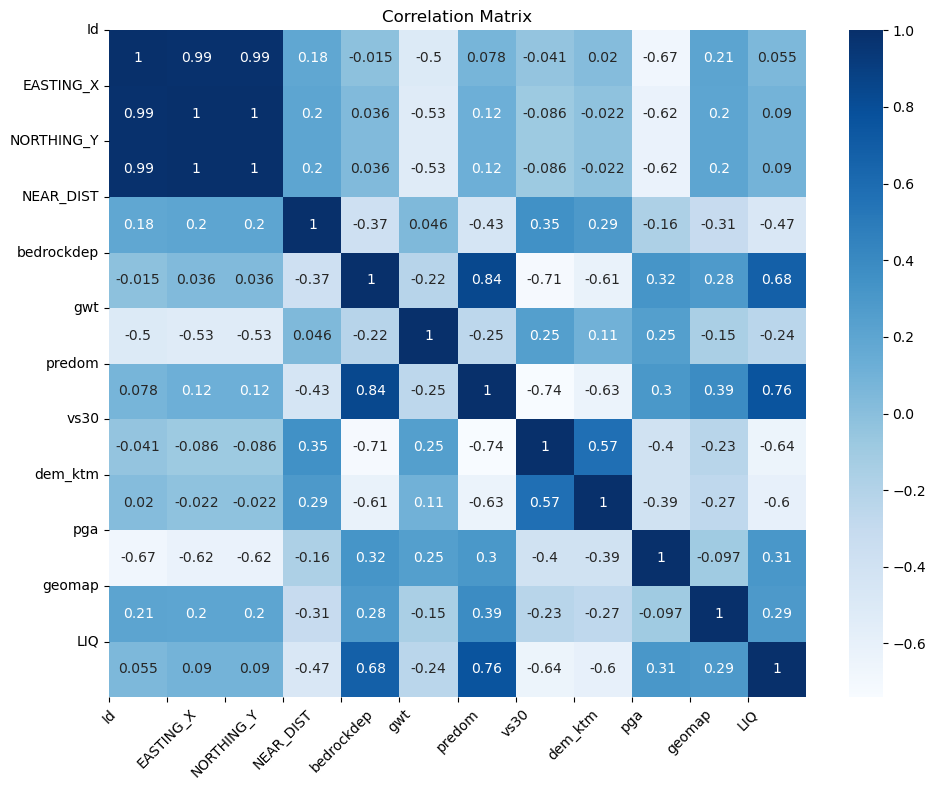

Variance Inflation Factor (VIF):
        VIF    features
0  2.633816   NEAR_DIST
1  8.467769  bedrockdep
2  8.504540        vs30
3  8.949885      predom
4  5.025018         pga
5  6.160987      geomap
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
Best Score: 0.888448036627875
Accuracy: 0.884
Precision: 0.838
Recall: 0.849
F1 Score: 0.844
AUC Score (Test): 0.947
AUC Error (Test): 0.053
Cohen Kappa Score: 0.751


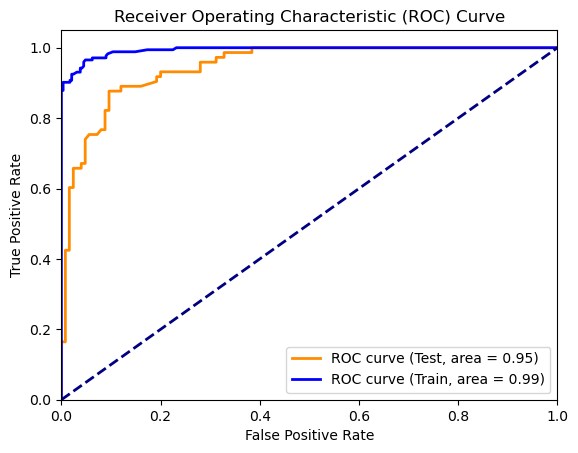

Feature Importance (Information Gain Ratio):
Feature 1: NEAR_DIST (importance: 0.164)
Feature 2: bedrockdep (importance: 0.282)
Feature 3: vs30 (importance: 0.278)
Feature 4: predom (importance: 0.343)
Feature 5: pga (importance: 0.143)
Feature 6: geomap (importance: 0.318)


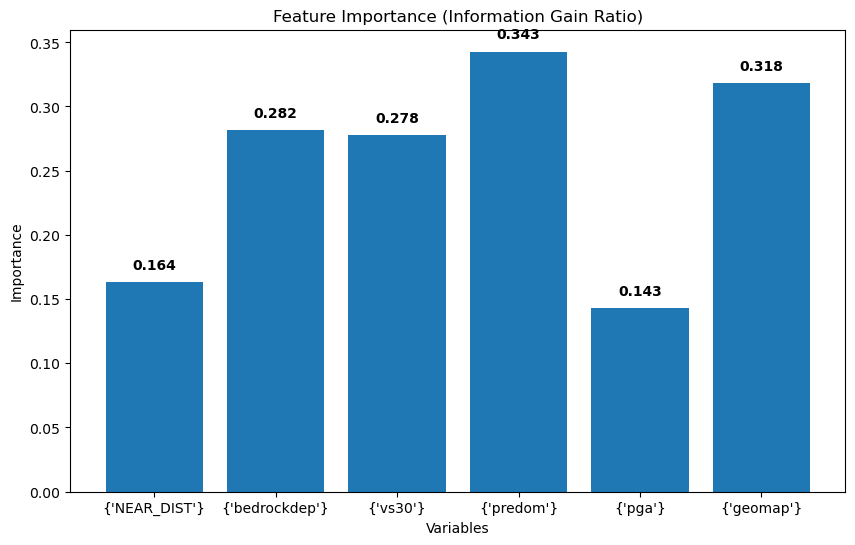

Confusion Matrix:
[[113  12]
 [ 11  62]]
True Positive Rate: 0.849
False Positive Rate: 0.096
True Negative Rate: 0.904
False Negative Rate: 0.151


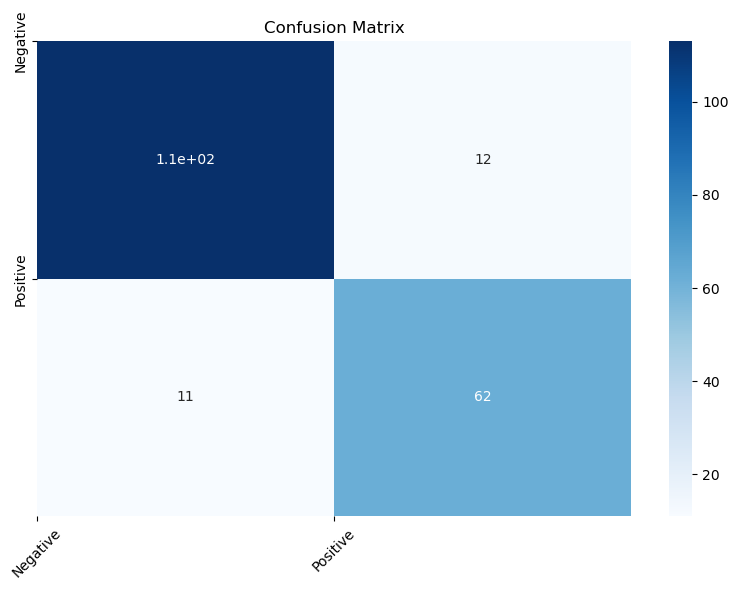

In [11]:
### FOR HYPERTUNING ONLY ###
## MINIMUM ETA = 9 MMINUTES ##

# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif

# Define constants
TEST_SIZE = 0.3
RANDOM_STATE = 36
N_ESTIMATORS = [0, 50, 100, 200, 300, 400, 500]
MAX_DEPTH = [None, 3, 5, 7, 10, 20, 30]
LEARNING_RATE = [0.0001, 0.001, 0.01, 0.1, 1]

# Load the dataset from a CSV file
file_path = "C:\\Users\\LE\\Downloads\\THESIS\\Program\\CSV\\GRID_LABEL_KTMBASIN_1KM_Classify.csv"
data = pd.read_csv(file_path)

# Calculate correlation of the dataset
correlation_matrix = data.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Draw heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title("Correlation Matrix")
tick_marks = [i for i in range(len(data.columns))]
plt.xticks(tick_marks, data.columns, rotation=45)
plt.yticks(tick_marks, data.columns)
plt.tight_layout()
plt.show()

# Preprocess the data
X = data[["NEAR_DIST", "bedrockdep", "vs30", "predom", "pga", "geomap"]]
y = data["LIQ"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Calculate VIF
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['features'] = X_train.columns
print("Variance Inflation Factor (VIF):")
print(vif)

# Select a model based on the problem's requirements
model_type = "classifier"
if model_type == "classifier":
    model = XGBClassifier(random_state=RANDOM_STATE)
elif model_type == "regressor":
    model = XGBRegressor(random_state=RANDOM_STATE)

# Define hyperparameter tuning space
param_grid = {
    'n_estimators': N_ESTIMATORS,
    'max_depth': MAX_DEPTH,
    'learning_rate': LEARNING_RATE
}

# Perform hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Train a new model with the best hyperparameters and evaluate its performance
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
auc_score_test = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
auc_error_test = 1 - auc_score_test
kappa = cohen_kappa_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"AUC Score (Test): {auc_score_test:.3f}")
print(f"AUC Error (Test): {auc_error_test:.3f}")
print(f"Cohen Kappa Score: {kappa:.3f}")

# Plot AUROC curve for test data
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot AUROC curve for train data
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
roc_auc_train = auc(fpr_train, tpr_train)

# Plot AUROC curves for both test and train data
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (Test, area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve (Train, area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate feature importance using Information Gain Ratio
information_gain_ratio = mutual_info_classif(X_train, y_train)
print("Feature Importance (Information Gain Ratio):")
for i, importance in enumerate(information_gain_ratio):
    print(f"Feature {i+1}: {X.columns[i]} (importance: {importance:.3f})")

# Draw bar chart for feature importance using Information Gain Ratio
plt.figure(figsize=(10, 6))
plt.bar(range(len(information_gain_ratio)), information_gain_ratio, align="center")
plt.xticks(range(len(information_gain_ratio)), [{X.columns[i]} for i in range(len(information_gain_ratio))])
plt.xlabel("Variables")
plt.ylabel("Importance")
plt.title("Feature Importance (Information Gain Ratio)")
for i,v in enumerate(information_gain_ratio):
    plt.text(i,v+0.01,f"{v:.3f}", ha="center", weight="bold")
plt.show()

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_mat)

# Calculate true positive rate, false positive rate, true negative rate, false negative rate
tn, fp, fn, tp = conf_mat.ravel()
tpr = tp / (tp + fn)  # True positive rate
fpr = fp / (fp + tn)  # False positive rate
tnr = tn / (tn + fp)  # True negative rate
fnr = fn / (fn + tp)  # False negative rate

print(f"True Positive Rate: {tpr:.3f}")
print(f"False Positive Rate: {fpr:.3f}")
print(f"True Negative Rate: {tnr:.3f}")
print(f"False Negative Rate: {fnr:.3f}")

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues')
plt.title("Confusion Matrix")
tick_marks = [i for i in range(2)]
plt.xticks(tick_marks, ["Negative", "Positive"], rotation=45)
plt.yticks(tick_marks, ["Negative", "Positive"])
plt.tight_layout()
plt.show()